In [48]:
from bs4 import BeautifulSoup
import urllib2
import time
import re
import us
import os.path

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.cross_validation import train_test_split

import seaborn as sns
import plotly.plotly as py
from plotly.graph_objs import *
import plotly.graph_objs as go
%matplotlib inline

pd.options.display.max_columns = 50
pd.options.display.max_colwidth = 300

In [49]:
class IndeedJobs:
    'General indeed job scraper we may need it to search other kind of job or queries'
    _res_in_page=50
    job_title=""
    # class initializer
    # it takes a job title and some conditions
    def __init__(self, job_title, search_conditions={}):
        
        # query part of the url
        self.query = ""
        # conditions of search goes here
        search={}
        if search_conditions:
            search = search_conditions
        if ~('sort' in search): search['sort']='date'
        if ~('limit' in search): search['limit']=str(IndeedJobs._res_in_page)
        if ~('start' in search): search['start']=''
        search['q']=job_title.replace(" ", "+")
        
        # self.query is the query generated based on conditions
        self.query += "?q={}".format(search['q'])
        self.query += "&sort={}".format(search['sort'])
        self.query += "&limit={}".format(search['limit'])
        
        # job title - no need but nice to have!!!
        IndeedJobs.job_title = job_title
        # default to show results per page.
        IndeedJobs._res_in_page = int(search['limit'])
        
    # Generates url based on page number
    def _get_url(self, page_number=0):
        return "http://www.indeed.com/jobs"+self.query+"&start={}".format(page_number*IndeedJobs._res_in_page)
    # Gets each of job listings
    def _result_rows(self, soup):
        return soup.find('td', {'id': "resultsCol"}).find_all('div', {'class': "result"})
    # Gets the title of the job listing
    def _get_title(self, result):
        if result.find_all('a', {'class': 'jobtitle'}):
            return result.find_all('a', {'class': 'jobtitle'})[0].text.lstrip().rstrip()
        if result.find_all('h2', {'class': 'jobtitle'}):
            return result.find_all('h2', {'class': 'jobtitle'})[0].text.lstrip().rstrip()
    # Getes the company posting the job
    def _get_company(self, result):
        return result.find('span').text.lstrip().rstrip()
    # Gets location of the job
    def _get_location(self, result):
        res = result.find('span', {'class':'location'}).text.lstrip().rstrip().split(', ')
                
        # This one is used to separate state and city if a city is in result
        if len(res)>1:
            res[1] = res[1].split(' ')[0]
        # There are some cases that this shit happens
        if (res[0]==unicode('United States') or 
            res[0]==unicode('Remote') or res[0]==unicode('Home Based') 
            or res[0]==unicode('Field')):
            return {'city':None,'state':None}
        # If city and state is there
        if len(res) > 1:
            return {'city':res[0],'state':res[1]}
        # Just a state is mentioned and sometimes its not in two char code so we need 'us' lib
        else:
            return {'city':None,'state':us.states.lookup(unicode(res[0].replace(' State', ''))).abbr}
    # Gets date of the posting
    def _get_date(self, result):
        return result.find('span', {'class':'date'}).text.lstrip().rstrip()
    # Gets summary of posting
    def _get_summary(self, result):
        return result.find('span', {'class':'summary'}).text.lstrip().rstrip()
    # Gets salary
    def _get_salary(self, result):    
        salary = ""
        # This is for sasllary on page
        if result.find_all('nobr'):
            salary = result.find_all('nobr')[0].text.lstrip().rstrip()
        # This is for salary on sponsored listings
        elif result.find_all('div', {"class":"sjcl"}):
            if result.find_all('div', {"class":"sjcl"})[0].find_all('div'):
                salary = result.find_all('div', {"class":"sjcl"})[0].find_all('div')[0].text.lstrip().rstrip()
        # if there is no salary
        if salary=='':
            return {'min':None,'max':None,'mean':None}
        # order of things is important
        salary=salary.replace('$', '').replace('-', '').replace(' an', ' ').replace(' a', ' ').replace(',', '')
        salary=str(salary).split(' ')
        sal = {}
        sal['min']=float(salary[0])
        sal['max']=float(salary[0]) if len(salary)==3 else float(salary[2])
        sal['mean']=np.mean([sal['min'],sal['max']])
        # hourly salary
        if salary[-1]=='hour':
            sal['mean']=sal['mean']*40*52
        # daily salary
        elif salary[-1]=='day':
            sal['mean']=sal['mean']*5*52
        # monthly salary
        elif salary[-1]=='month':
            sal['mean']=sal['mean']*12
        return sal
    # Gets results per each page
    def _get_page_data(self, page_number=0):
        soup=BeautifulSoup(urllib2.urlopen(self._get_url(page_number)).read(), "lxml")
        results=[]
        for result in self._result_rows(soup):
            job={}
            job["title"]=self._get_title(result)
            job["company"]=self._get_company(result)
            job["city"]=self._get_location(result)['city']
            job["state"]=self._get_location(result)['state']
            job["date"]=self._get_date(result)
            job["summary"]=self._get_summary(result)
            salary=self._get_salary(result)
            job["min_salary"]=salary['min']
            job["max_salary"]=salary['max']
            job["apr_yearly"]=salary['mean']
            results.append(job)
        return results
    # Gets dataset for all pages
    def get_df(self, pages=1):
        results=[]
        for page in range(0, pages):
            results+=self._get_page_data(page)
            time.sleep(1)
        return pd.DataFrame(results).drop_duplicates()

In [50]:
fname='../assets/dataset/jobs.csv'
all_jobs = ""
if os.path.isfile(fname):
    all_jobs = pd.read_csv(fname).drop(['Unnamed: 0'], axis=1)
else:
    all_jobs = IndeedJobs('data science').get_df(500)
    all_jobs.to_csv('../assets/dataset/jobs.csv', encoding='utf-8')

In [51]:
all_jobs.head(3)

,apr_yearly,city,company,date,max_salary,min_salary,state,summary,title
0,NaN,Boston,Boston University,Just posted,NaN,NaN,MA,Candidates are expected to be outstanding scholars with a proven record of achievements and demonstrated potential to lead and sustain an ambitious research...,"FACULTY POSTIONS IN DATA SCIENCES, Data Science Initiative"
1,NaN,Bloomington,State Farm Mutual Automobile Insurance Company,Just posted,NaN,NaN,IL,"Our Data Science analysts do much more than just search large data sets & crunch numbers all day! Our data science team employs sophisticated, statistical...",Data Scientist
2,NaN,Chicago,Illinois Technology Association,Just posted,NaN,NaN,IL,Collaborate with data scientists to design and develop processes to further business unit and company-wide data science initiatives on a common data platform....,GrubHub - Data Engineer


In [13]:
def plot_data(df, item):
    scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]
    return [ dict(
            type='choropleth',
            colorscale = scl,
            autocolorscale = False,
            locations = df['state'],
            z = piv[item].astype(float),
            locationmode = 'USA-states',
    #         text = df['text'],
            marker = dict(
                line = dict (
                    color = 'rgb(255,255,255)',
                    width = 2
                )
            ),
            colorbar = dict(
                title = "Salary"
            )
        ) ]
def plot_layout(title):
    return dict(
            title = title,
            geo = dict(
                scope='usa',
                projection=dict( type='albers usa' ),
                showlakes = True,
                lakecolor = 'rgb(255, 255, 255)',
            ),
        )

In [18]:
piv = pd.pivot_table(all_jobs, index='state', 
                     values=['apr_yearly'],
                     aggfunc=[np.mean, np.max, np.min]                     
                    ).reset_index()
piv.columns = piv.columns.droplevel(1)
piv = piv.dropna()

In [19]:
fig = dict( data=plot_data(piv, 'mean'), layout=plot_layout('Mean offered Salary') )
py.iplot( fig, filename='MeanSalary' )

In [20]:
fig = dict( data=plot_data(piv, 'amax'), layout=plot_layout('Max offered Salary') )
py.iplot( fig, filename='MaxSalary' )

In [21]:
fig = dict( data=plot_data(piv, 'amin'), layout=plot_layout('Min offered Salary') )
py.iplot( fig, filename='MinSalary' )

In [15]:
piv = pd.pivot_table(all_jobs.dropna(), index='company', 
                     values=['apr_yearly'],
                     aggfunc=[np.mean, np.max, np.min, np.count_nonzero]                     
                    ).reset_index()
piv.columns = piv.columns.droplevel(1)
piv.sort_values(['count_nonzero'], ascending=[False])
piv = piv.dropna()
piv1 = piv[(piv['count_nonzero']>1.0)]

In [16]:
trace1 = go.Bar(
    x=list(piv1.company),
    y=list(piv1['mean']),
    name='Mean'
)
trace2 = go.Bar(
    x=list(piv1.company),
    y=list(piv1.amax),
    name='Maximum',
    text=list(piv1.count_nonzero)
)
trace3 = go.Bar(
    x=list(piv1.company),
    y=list(piv1.amin),
    name='Minimum'
)

data = [trace1, trace2, trace3]
layout = go.Layout(
    barmode='group'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='grouped-salary')

In [82]:
v = CountVectorizer(
    binary=True,  # Create binary features
    stop_words='english', # Ignore common words such as 'the', 'and'
    max_features=20, # Only use the top 50 most common words
)

In [83]:
summary_tokens = v.fit_transform(all_jobs.summary).todense()
summary_tokens = pd.DataFrame(summary_tokens, columns=v.get_feature_names())
summary_tokens.head(3)

,analysis,bachelor,bs,business,computer,data,degree,engineering,equivalent,experience,field,information,management,related,science,sciences,systems,technical,technology,years
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [84]:
title_tokens = v.fit_transform(all_jobs.title).todense()
title_tokens = pd.DataFrame(title_tokens, columns=v.get_feature_names())
title_tokens.head(3)

,analyst,architect,associate,business,data,developer,development,director,engineer,lead,manager,research,science,scientist,security,senior,software,specialist,sr,systems
0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [85]:
merged_tokens = pd.concat([summary_tokens, title_tokens], axis=1)
merged_tokens = merged_tokens.groupby(merged_tokens.columns, axis=1).sum()
merged_tokens.head(3)

,analysis,analyst,architect,associate,bachelor,bs,business,computer,data,degree,developer,development,director,engineer,engineering,equivalent,experience,field,information,lead,management,manager,related,research,science,sciences,scientist,security,senior,software,specialist,sr,systems,technical,technology,years
0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [86]:
jobs_data = pd.get_dummies(all_jobs, columns=['state'])
jobs_data.head(3)

,apr_yearly,city,company,date,max_salary,min_salary,summary,title,state_AK,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,state_GA,state_HI,state_IA,state_IL,state_IN,state_KS,state_KY,...,state_MS,state_MT,state_NC,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
0,NaN,Boston,Boston University,Just posted,NaN,NaN,Candidates are expected to be outstanding scholars with a proven record of achievements and demonstrated potential to lead and sustain an ambitious research...,"FACULTY POSTIONS IN DATA SCIENCES, Data Science Initiative",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,NaN,Bloomington,State Farm Mutual Automobile Insurance Company,Just posted,NaN,NaN,"Our Data Science analysts do much more than just search large data sets & crunch numbers all day! Our data science team employs sophisticated, statistical...",Data Scientist,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NaN,Chicago,Illinois Technology Association,Just posted,NaN,NaN,Collaborate with data scientists to design and develop processes to further business unit and company-wide data science initiatives on a common data platform....,GrubHub - Data Engineer,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [87]:
jobs_data=pd.concat([jobs_data, merged_tokens], axis=1)

In [88]:
jobs_with_salary=jobs_data[jobs_data['apr_yearly'].notnull()]
jobs_with_salary.head(3)

,apr_yearly,city,company,date,max_salary,min_salary,summary,title,state_AK,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,state_GA,state_HI,state_IA,state_IL,state_IN,state_KS,state_KY,...,development,director,engineer,engineering,equivalent,experience,field,information,lead,management,manager,related,research,science,sciences,scientist,security,senior,software,specialist,sr,systems,technical,technology,years
3,49545.6,Fontana,Fontana Unified School District,Just posted,23.82,23.82,Strong data analysis and data modeling skills. ELECTRONIC DATA ANALYST. Two years full-time data processing with one year full-time electronic data analysis...,ELECTRONIC DATA ANALYST- Bulletin -16,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
6,34279.0,Hinds County,State of Mississippi,Just posted,34279.00,34279.00,"An Associate's Degree from an accredited two-year college in computer science, data processing, business information systems, or a related field;...",Systems Administrator II,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,2,0,0,0
8,69612.0,Lake County,State of Illinois,Just posted,6990.00,4612.00,Performs liaison activities between users and host computer support staff in order to maintain departmental databases and data entry functions;...,Information Services Specialist II - Opt C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [89]:
is_high_paid = (jobs_with_salary['apr_yearly']>=70000)
is_high_paid.head(3)

3    False
6    False
8    False
Name: apr_yearly, dtype: bool

In [90]:
jobs_with_salary=jobs_with_salary.drop(
    ['apr_yearly', 'max_salary', 'min_salary', 'summary', 'title', 'date', 'company', 'city']
    , axis=1)
jobs_with_salary.head(3)

,state_AK,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,state_GA,state_HI,state_IA,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_MI,state_MN,state_MO,state_MS,state_MT,...,development,director,engineer,engineering,equivalent,experience,field,information,lead,management,manager,related,research,science,sciences,scientist,security,senior,software,specialist,sr,systems,technical,technology,years
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,2,0,0,0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [91]:
y=is_high_paid
X=jobs_with_salary
print y.shape, X.shape

(111,) (111, 84)


In [92]:
log_model_1 = LogisticRegression(penalty='l1', C=0.1)
print log_model_1.fit(X,y)
print log_model_1.score(X,y)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.576576576577


In [93]:
log_model_2 = LogisticRegression(penalty='l1', C=1)
print log_model_2.fit(X,y)
print log_model_2.score(X,y)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.783783783784


In [94]:
log_model_3 = LogisticRegression(penalty='l1', C=.09)
print log_model_3.fit(X,y)
print log_model_3.score(X,y)

LogisticRegression(C=0.09, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.576576576577


In [95]:
model = LogisticRegression()
Cs = [.01, .03, .04, .05, 0.7, .08, .09, 1, 10, 50]
Ls = ['l1', 'l2']
grid = GridSearchCV(estimator=model, 
                    param_grid={'C': Cs,
                                'penalty': Ls
                               },
                    cv = 6
                   )

In [96]:
grid

GridSearchCV(cv=6, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.01, 0.03, 0.04, 0.05, 0.7, 0.08, 0.09, 1, 10, 50]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [97]:
grid.fit(X,y)

GridSearchCV(cv=6, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.01, 0.03, 0.04, 0.05, 0.7, 0.08, 0.09, 1, 10, 50]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [98]:
print grid.best_estimator_
print grid.best_score_

LogisticRegression(C=0.08, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.612612612613


In [99]:
predictions = grid.best_estimator_.predict(X)

In [100]:
confusion_matrix(y, predictions)

array([[62,  2],
       [25, 22]])

In [101]:
print classification_report(y, predictions)

             precision    recall  f1-score   support

      False       0.71      0.97      0.82        64
       True       0.92      0.47      0.62        47

avg / total       0.80      0.76      0.74       111



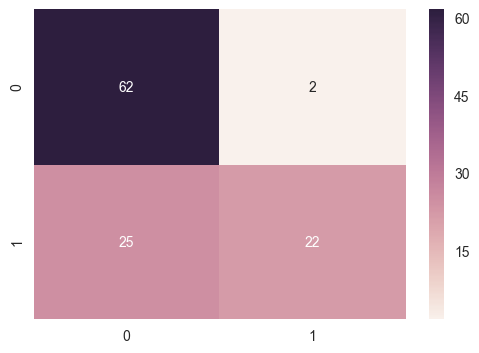

In [102]:
sns.heatmap(confusion_matrix(y, predictions), annot=True)

In [103]:
x_train, x_test, y_train, y_test = train_test_split(X, y)
print x_train.shape, y_train.shape
print x_test.shape, y_test.shape

(83, 84) (83,)
(28, 84) (28,)


In [104]:
logistic_reg = LogisticRegression()
model = LogisticRegression()
Cs = [.01, .02, .03, .04, .05, 0.07, .08, .09, .1, .5, 1]
Ls = ['l1', 'l2']
grid = GridSearchCV(estimator=model, 
                    param_grid={'C': Cs,
                                'penalty': Ls
                               },
                    cv = 6
                   )

In [105]:
grid.fit(x_train,y_train)
print grid.best_estimator_
print grid.best_score_

LogisticRegression(C=0.03, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.626506024096


In [106]:
grid.fit(x_test,y_test)
print grid.best_estimator_
print grid.best_score_

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.714285714286


In [107]:
grid.fit(X,y)
print grid.best_estimator_
print grid.best_score_

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.621621621622
